# Projet 6 : Classifiez automatiquement des biens de consommation.

## Classification supervisée des images

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
* [3. Prétraitement des images](#partie3)
* [4. Classification des images avec CNN Transfer Learning](#partie4)
    * [4.1 Classification sans optimisation](#partie4.1)
    * [4.2 Optimisation des hyperparamètres](#partie4.2)
    * [4.3 Data Augmentation](#partie4.3)
* [5. Conclusion](#partie5)

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Dans cette dernière étape, l’objectif est de mettre en œuvre une classification supervisée complète des images en utilisant le modèle VGG16 via Transfer Learning. Cette étape sert à valider la faisabilité d'une classification automatique précise en s'appuyant sur des techniques avancées de deep learning.

Les principales étapes de ce livrable sont :

- Préparation des données : Division des images en ensembles d'entraînement, de validation et de test.
- Entraînement du modèle VGG16 : Fine-tuning du modèle VGG16 en gelant certaines couches et en ajustant d'autres spécifiquement pour la classification des images de notre projet.
- Évaluation du modèle : Calcul des métriques de performance, telles que l'accuracy sur les ensembles de validation et de test, et visualisation des courbes d'apprentissage pour identifier d'éventuels phénomènes d'overfitting.
- Affichage des résultats : Affichage de la matrice de confusion pour évaluer la performance du modèle sur les différentes catégories de produits.

Ce livrable a pour but de démontrer que la classification supervisée des images avec VGG16 est non seulement faisable mais également performante dans le contexte de ce projet.

## <font color='red'>2. Préparation de l'environnement</font><a class="anchor" id="partie2"></a>

### <font color='purple'>Préparation des données</font>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
import os
import gc
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten
from keras import backend as K

In [ ]:
K.clear_session()
gc.collect()

0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger le fichier CSV dans un data frame
df = pd.read_csv('/content/drive/My Drive/projet_6/df_classification_copy.csv')

In [ ]:
# Définir le chemin de base des images
chemin_images = '/content/drive/My Drive/projet_6/Images/'

## <font color='red'>3. Prétraitement des images</font><a class="anchor" id="partie3"></a>

In [ ]:
# Séparation du jeu de données
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['cat_1'], test_size=0.2, random_state=42)

# Convertir les chemins des images en listes
X_train = list(X_train)
X_test = list(X_test)

# Encoder les labels (cat_1)
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Convertir les labels encodés en one-hot encoding
y_train_categorical = to_categorical(y_train_encoded, num_classes=7)
y_test_categorical = to_categorical(y_test_encoded, num_classes=7)

# Prétraitement des images pour qu'elles soient exploitables par VGG16
def prepare_images_vgg16(image_paths, target_size=(224, 224)):
    """
    Prépare les images pour qu'elles soient exploitables par VGG16 en les redimensionnant et en les transformant en tableau.

    Parameters:
    image_paths (list): Liste des chemins d'accès aux images.
    target_size (tuple): Taille cible à laquelle redimensionner les images (par défaut (224, 224)).

    Returns:
    numpy.ndarray: Un tableau contenant les images prétraitées.
    """
    images = []
    for path in image_paths:
        image = load_img(os.path.join(chemin_images, path), target_size=target_size)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        images.append(image)

    return np.vstack(images)

# Préparation des images pour l'entraînement et le test
X_train_images = prepare_images_vgg16(X_train)
X_test_images = prepare_images_vgg16(X_test)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## <font color='red'>4. Classification des images avec CNN Transfer Learning</font><a class="anchor" id="partie4"></a>

### <font color='blue'>4.1 Classification sans optimisation</font><a class="anchor" id="partie4.1">

#### <font color='purple'>Création du modèle</font>

In [ ]:
# Fonction pour créer le modèle VGG16
def create_model_vgg16():
    """
    Crée un modèle de classification basé sur VGG16 avec des couches fully connected personnalisées.

    Returns:
    model (Model): Le modèle VGG16 modifié et compilé.
    """
    # Charger le modèle VGG16 pré-entraîné sans les couches fully connected
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Geler les couches du modèle VGG16 pour qu'elles ne soient pas réentraînées
    for layer in vgg_base.layers:
        layer.trainable = False

    # Ajouter des couches fully connected pour la classification
    x = vgg_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Créer le modèle final
    model = Model(inputs=vgg_base.input, outputs=predictions)

    # Compiler le modèle avec RMSprop comme optimiseur
    model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Créer le modèle
model_vgg = create_model_vgg16()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Afficher le résumé du modèle
model_vgg.summary()

print(f'X_train_images shape: {X_train_images.shape}')
print(f'y_train_categorical shape: {y_train_categorical.shape}')
print(f'X_test_images shape: {X_test_images.shape}')
print(f'y_test_categorical shape: {y_test_categorical.shape}')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

X_train_images shape: (840, 224, 224, 3)
y_train_categorical shape: (840, 7)
X_test_images shape: (210, 224, 224, 3)
y_test_categorical shape: (210, 7)


#### <font color='purple'>Callbacks</font>

In [ ]:
# Callbacks pour sauvegarder le meilleur modèle et utiliser early stopping
model_save_path = "models/best_vgg16_model.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, early_stop]

#### <font color='purple'>Entrainement du modèle</font>

In [ ]:
# Entraîner le modèle avec les callbacks pour sauvegarder le meilleur modèle
history = model_vgg.fit(
    X_train_images, y_train_categorical,
    epochs=40,
    batch_size=32,
    validation_data=(X_test_images, y_test_categorical),
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3834 - loss: 8.5335
Epoch 1: val_loss improved from inf to 1.57759, saving model to models/best_vgg16_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 667ms/step - accuracy: 0.3874 - loss: 8.4278 - val_accuracy: 0.7381 - val_loss: 1.5776
Epoch 2/40
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6878 - loss: 2.0692
Epoch 2: val_loss improved from 1.57759 to 1.15071, saving model to models/best_vgg16_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6880 - loss: 2.0727 - val_accuracy: 0.7619 - val_loss: 1.1507
Epoch 3/40
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7326 - loss: 1.4275
Epoch 3: val_loss improved from 1.15071 to 1.04625, saving model to models/best_vgg16_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.7339 - loss: 1.4157 - val_accuracy: 0.7810 - val_loss: 1.0462
Epoch 4/40
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7477 - loss: 1.0732
Epoch 4: val_loss 

#### <font color='purple'>Courbes d'apprentissage</font>

In [ ]:
# Fonction pour tracer les courbes de loss et d'accuracy
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label=f'Train Accuracy: {history.history["accuracy"][-1]:.4f}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy: {history.history["val_accuracy"][-1]:.4f}')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label=f'Train Loss: {history.history["loss"][-1]:.4f}')
    plt.plot(history.history['val_loss'], label=f'Val Loss: {history.history["val_loss"][-1]:.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

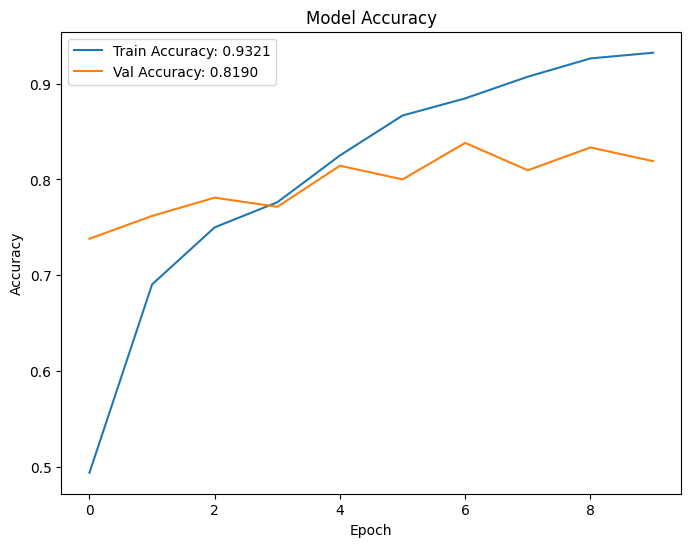

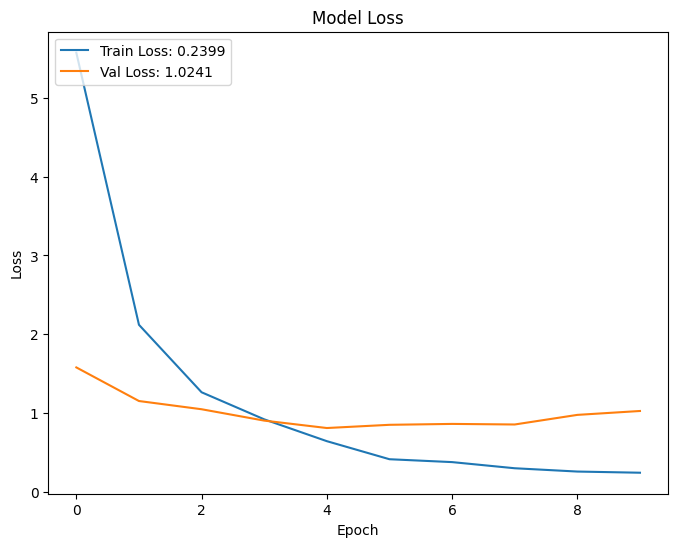

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63        27
           1       0.89      0.76      0.82        21
           2       0.94      0.84      0.89        38
           3       0.63      0.97      0.76        30
           4       0.93      0.71      0.81        35
           5       0.88      0.81      0.84        26
           6       0.94      0.97      0.96        33

    accuracy                           0.82       210
   macro avg       0.83      0.81      0.81       210
weighted avg       0.84      0.82      0.82       210

Confusion Matrix:
[[17  0  0  7  2  1  0]
 [ 3 16  1  1  0  0  0]
 [ 0  2 32  2  0  1  1]
 [ 0  0  0 29  0  1  0]
 [ 6  0  0  4 25  0  0]
 [ 1  0  1  2  0 21  1]
 [ 0  0  0  1  0  0 32]]


In [ ]:
# Tracer les courbes d'entraînement
plot_training_history(history)

# Prédire les classes pour les données de test
y_test_pred = model_vgg.predict(X_test_images)

# Convertir les prédictions en classes (catégories)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Convertir les labels one-hot encodés en classes (catégories)
y_test_true_classes = np.argmax(y_test_categorical, axis=1)

# Afficher le rapport de classification (precision, recall, f1-score, support)
print("Classification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

#### <font color='purple'>Scores et Matrice de confusion</font>

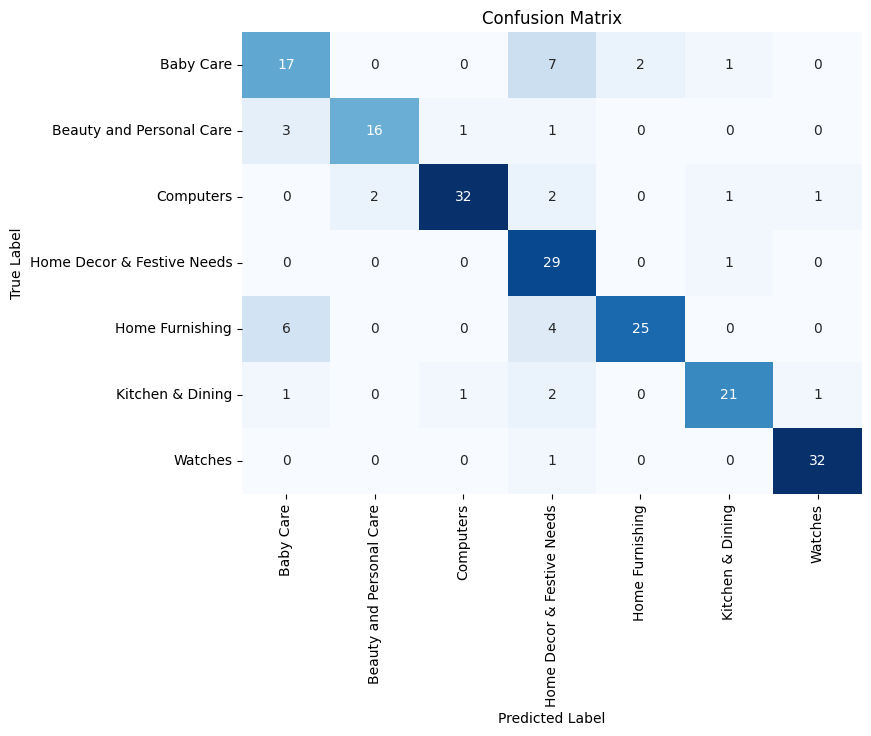

In [ ]:
# Afficher la matrice de confusion avec une heatmap
def plot_confusion_matrix(conf_matrix, categories):
    df_cm = pd.DataFrame(conf_matrix, index=categories, columns=categories)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Encoder les labels (cat_1)
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Convertir les labels encodés en one-hot encoding
y_train_categorical = to_categorical(y_train_encoded, num_classes=7)
y_test_categorical = to_categorical(y_test_encoded, num_classes=7)

# Récupérer les noms des catégories
categories = encoder.classes_

# Afficher la heatmap de la matrice de confusion
plot_confusion_matrix(conf_matrix, categories)

### <font color='blue'>4.2 Optimisation des hyperparamètres</font><a class="anchor" id="partie4.2">

#### <font color='purple'>Optimisation du modele avec différents hyperparametres</font>

In [ ]:
# Optimisateurs et hyperparamètres à tester
optimizers = [
    ('rmsprop', 0.001),
    ('adam', 0.001),
    ('sgd', 0.9),  # Momentum value is specified here for SGD
    ('sgd', 0.95)
]

# Fonctions de perte à tester
loss_functions = ['categorical_crossentropy', 'categorical_hinge']

# Dropout rates à tester
dropout_rates = [0.5, 0.3]

# Fonctions d'activation à tester
activations = ['relu', 'leaky_relu']

# Pooling strategies
pooling_strategies = ['GlobalAveragePooling2D', 'MaxPooling2D']

# Batch Sizes à tester
batch_sizes = [16, 32]

# Patience pour Early Stopping
patience_values = [5, 10]

In [ ]:
# Fonction pour créer le modèle VGG16 avec différents hyperparamètres
def create_model_vgg16(activation='relu', dropout_rate=0.5, pooling='GlobalAveragePooling2D', batch_normalization=False):
    """
    Crée un modèle VGG16 avec des hyperparamètres personnalisables.

    Parameters:
    activation (str): Fonction d'activation utilisée dans la couche dense (par défaut 'relu').
    dropout_rate (float): Taux de dropout appliqué à la couche fully connected (par défaut 0.5).
    pooling (str): Stratégie de pooling ('GlobalAveragePooling2D' ou 'MaxPooling2D', par défaut 'GlobalAveragePooling2D').
    batch_normalization (bool): Indique si une normalisation par batch est ajoutée (par défaut False).

    Returns:
    model (Model): Le modèle VGG16 modifié.
    """
    # Charger le modèle VGG16 pré-entraîné sans la couche fully connected
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg_base.layers:
        layer.trainable = False

    x = vgg_base.output

    # Pooling strategy
    if pooling == 'GlobalAveragePooling2D':
        x = GlobalAveragePooling2D()(x)
    else:
        # Utilisation de MaxPooling suivi de Flatten
        x = MaxPooling2D(pool_size=(7, 7))(x)
        x = Flatten()(x)

    # Ajouter une couche dense
    x = Dense(256, activation=activation)(x)

    # Normalisation par batch si sélectionnée
    if batch_normalization:
        x = BatchNormalization()(x)

    # Ajouter Dropout
    x = Dropout(dropout_rate)(x)

    # Ajouter la dernière couche de classification
    predictions = Dense(7, activation='softmax')(x)

    # Créer le modèle final
    model = Model(inputs=vgg_base.input, outputs=predictions)

    return model

In [ ]:
# Paramètres des callbacks
model_save_path = "models/best_vgg16_model_optimised.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, early_stop]

# Grille d'hyperparamètres
results = []

for optimizer_name, learning_rate in optimizers:
    for loss in loss_functions:
        for dropout_rate in dropout_rates:
            for activation in activations:
                for pooling in pooling_strategies:
                    for batch_size in batch_sizes:

                        # Réinitialiser le modèle à chaque itération
                        K.clear_session()

                        # Créer et compiler le modèle
                        model = create_model_vgg16(activation=activation, dropout_rate=dropout_rate, pooling=pooling)

                        # Recréer l'optimiseur pour chaque itération
                        if optimizer_name == 'rmsprop':
                            optimizer = RMSprop(learning_rate=learning_rate)
                        elif optimizer_name == 'adam':
                            optimizer = Adam(learning_rate=learning_rate)
                        elif optimizer_name == 'sgd':  # Pour le cas de SGD
                            optimizer = SGD(learning_rate=learning_rate, momentum=learning_rate)
                        else:
                            raise ValueError("Unknown optimizer name")

                        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                        # Entraîner le modèle
                        history = model.fit(
                            X_train_images, y_train_categorical,
                            epochs=20,
                            batch_size=batch_size,
                            validation_data=(X_test_images, y_test_categorical),
                            callbacks=callbacks_list,
                            verbose=0  # Mettre verbose à 1 si tu veux suivre l'entraînement
                        )

                        # Évaluer et stocker les résultats
                        val_loss, val_accuracy = model.evaluate(X_test_images, y_test_categorical, verbose=0)
                        results.append((optimizer_name, loss, dropout_rate, activation, pooling, batch_size, val_loss, val_accuracy))

# Afficher les résultats
best_result = min(results, key=lambda x: x[6])  # Trier par validation loss
print("Best hyperparameters:", best_result)


Epoch 1: val_loss improved from inf to 1.51643, saving model to models/best_vgg16_model_optimised.keras

Epoch 2: val_loss improved from 1.51643 to 1.38232, saving model to models/best_vgg16_model_optimised.keras

Epoch 3: val_loss improved from 1.38232 to 0.96605, saving model to models/best_vgg16_model_optimised.keras

Epoch 4: val_loss did not improve from 0.96605

Epoch 5: val_loss improved from 0.96605 to 0.92484, saving model to models/best_vgg16_model_optimised.keras

Epoch 6: val_loss did not improve from 0.92484

Epoch 7: val_loss did not improve from 0.92484

Epoch 8: val_loss did not improve from 0.92484

Epoch 9: val_loss did not improve from 0.92484

Epoch 10: val_loss did not improve from 0.92484
Epoch 10: early stopping

Epoch 1: val_loss did not improve from 0.92484

Epoch 2: val_loss did not improve from 0.92484

Epoch 3: val_loss improved from 0.92484 to 0.85544, saving model to models/best_vgg16_model_optimised.keras

Epoch 4: val_loss improved from 0.85544 to 0.850

#### <font color='purple'>Test du modele avec les meilleurs hyperparametres</font>

In [ ]:
# Fonction pour créer le modèle avec les hyperparamètres optimisés
def create_optimized_model():
    """
    Crée un modèle VGG16 avec des hyperparamètres optimisés pour la classification.

    Returns:
    model (Model): Le modèle VGG16 modifié avec des hyperparamètres optimisés.
    """
    # Charger le modèle VGG16 pré-entraîné sans la couche fully connected
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg_base.layers:
        layer.trainable = False

    # Ajouter les couches de pooling et fully connected selon les hyperparamètres
    x = vgg_base.output
    x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling2D
    x = Dense(256, activation='relu')(x)  # Fonction d'activation ReLU
    x = Dropout(0.4)(x)  # Taux de Dropout de 0.4
    predictions = Dense(7, activation='softmax')(x)  # Sortie softmax pour 7 classes

    # Créer le modèle final
    model = Model(inputs=vgg_base.input, outputs=predictions)

    # Compiler le modèle avec RMSprop et categorical_hinge
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_hinge', metrics=['accuracy'])

    return model

# Créer et compiler le modèle
model_optimized = create_optimized_model()

# Paramètres des callbacks
model_save_path = "models/best_vgg16_model_optimized.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, early_stop]

# Entraîner le modèle avec les meilleurs hyperparamètres
history_optimized = model_optimized.fit(
    X_train_images, y_train_categorical,
    epochs=16,
    batch_size=32,  # Batch size optimal
    validation_data=(X_test_images, y_test_categorical),
    callbacks=callbacks_list,
    verbose=1
)

# Afficher les résultats
val_loss, val_accuracy = model_optimized.evaluate(X_test_images, y_test_categorical, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2024 - loss: 1.5621
Epoch 1: val_loss improved from inf to 1.46798, saving model to models/best_vgg16_model_optimized.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.2030 - loss: 1.5613 - val_accuracy: 0.2571 - val_loss: 1.4680
Epoch 2/16
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3372 - loss: 1.2992
Epoch 2: val_loss improved from 1.46798 to 1.11276, saving model to models/best_vgg16_model_optimized.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.3396 - loss: 1.2944 - val_accuracy: 0.4286 - val_loss: 1.1128
Epoch 3/16
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4974 - loss: 0.9893
Epoch 3: val_loss improved from 1.11276 to 0.96545, saving model to models/best_vgg16_model_optimized.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4952 - loss: 0.9938 - val_accuracy: 0.5048 - val_loss: 0.9655
Epoch 4/16
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5296 - l

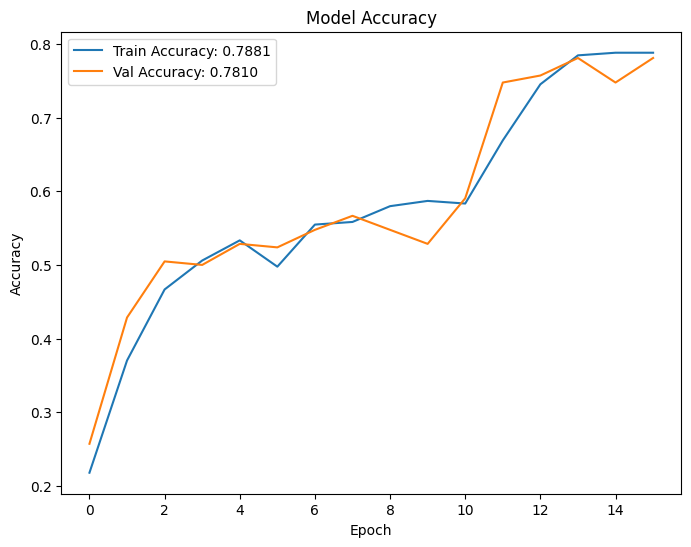

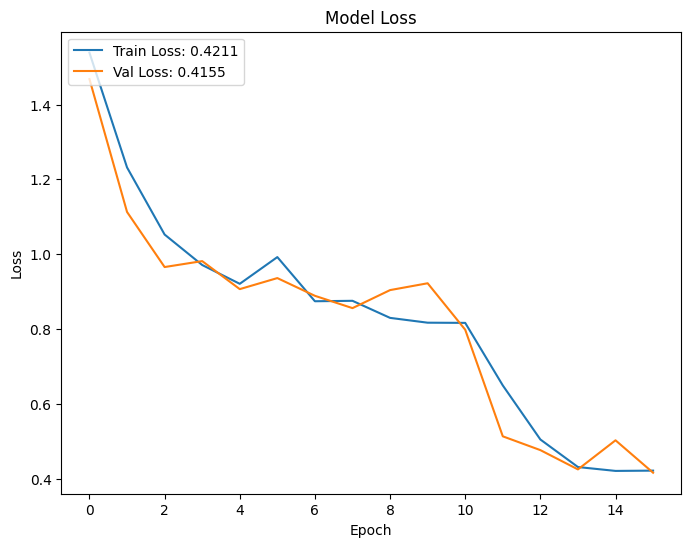

In [ ]:
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(8, 6))
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    plt.plot(history.history['accuracy'], label=f'Train Accuracy: {train_acc:.4f}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy: {val_acc:.4f}')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Loss
    plt.figure(figsize=(8, 6))
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    plt.plot(history.history['loss'], label=f'Train Loss: {train_loss:.4f}')
    plt.plot(history.history['val_loss'], label=f'Val Loss: {val_loss:.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Tracer les courbes d'apprentissage
plot_training_history(history_optimized)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step


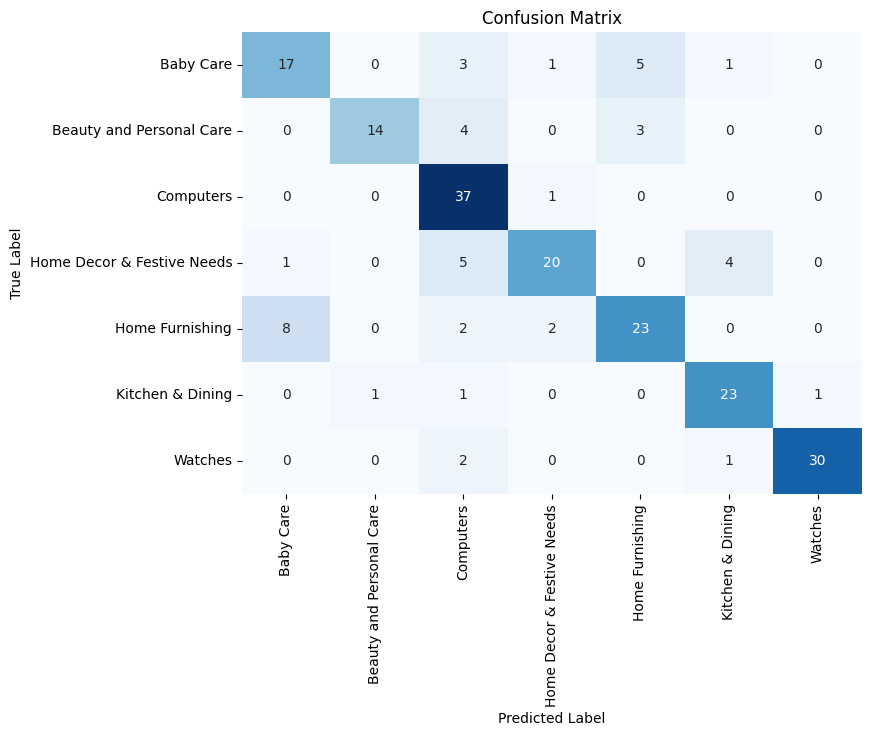

In [ ]:
# Prédire les classes pour les données de test
y_test_pred = model_optimized.predict(X_test_images)

# Convertir les prédictions en classes (catégories)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Convertir les labels one-hot encodés en classes (catégories)
y_test_true_classes = np.argmax(y_test_categorical, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Afficher la heatmap de la matrice de confusion
plot_confusion_matrix(conf_matrix, categories)

### <font color='blue'>4.3 Data Augmentation</font><a class="anchor" id="partie4.3">

In [ ]:
# Configuration de la data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,        # Rotation des images
    width_shift_range=0.2,    # Translation horizontale
    height_shift_range=0.2,   # Translation verticale
    shear_range=0.2,          # Transformation en cisaillement
    zoom_range=0.2,           # Zoom
    horizontal_flip=True,     # Flip horizontal
    fill_mode='nearest'       # Remplissage des pixels manquants
)

In [ ]:
# Pas de data augmentation pour les images de validation
val_datagen = ImageDataGenerator()

# Générer des lots d'images augmentées
train_generator = train_datagen.flow(
    X_train_images, y_train_categorical,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_test_images, y_test_categorical,
    batch_size=32
)


In [ ]:
# Entraîner le modèle avec la data augmentation
history_augmented = model_optimized.fit(
    train_generator,
    epochs=20,  # Tu peux ajuster ce nombre en fonction de tes observations
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1  # Affichage des étapes d'entraînement
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8589 - loss: 0.2822
Epoch 1: val_loss did not improve from 0.29073
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - accuracy: 0.8579 - loss: 0.2843 - val_accuracy: 0.8095 - val_loss: 0.3792
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8696 - loss: 0.2634
Epoch 2: val_loss did not improve from 0.29073
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.8692 - loss: 0.2644 - val_accuracy: 0.8190 - val_loss: 0.3540
Epoch 3/20
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8502 - loss: 0.3047
Epoch 3: val_loss did not improve from 0.29073
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.8498 - loss: 0.3056 - val_accuracy: 0.7952 - val_loss: 0.4019
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8229 - loss: 0.3527
Epoch 4: val_loss did not improve from 0.29073
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.8234 - loss: 0.3517 - val_accuracy: 0.8429 - val_loss: 0.3108


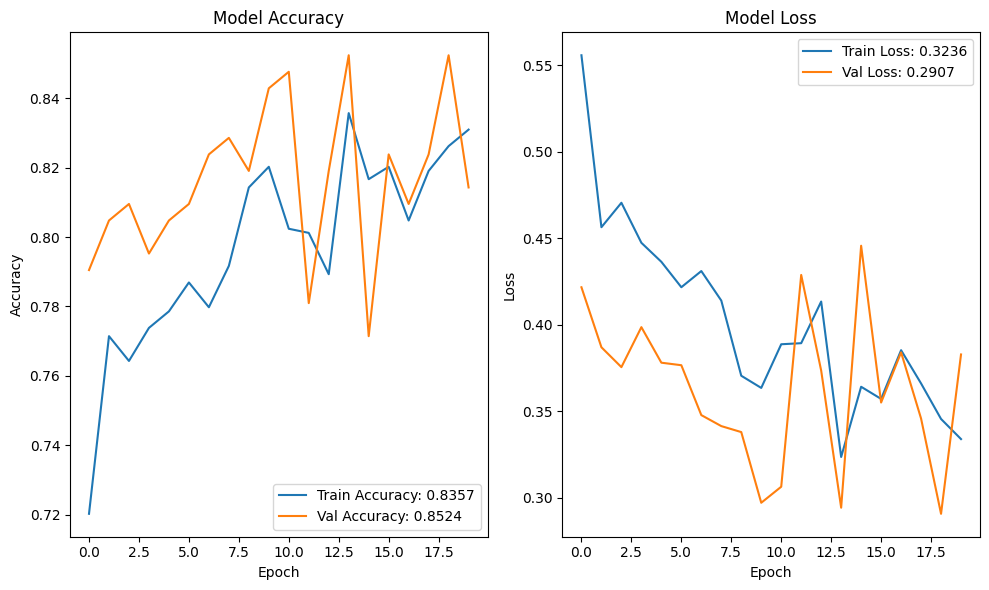

In [ ]:
def plot_learning_curves(history):
    # Plot de la courbe de l'accuracy
    plt.figure(figsize=(10, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Train Accuracy: {max(history.history["accuracy"]):.4f}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy: {max(history.history["val_accuracy"]):.4f}')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Train Loss: {min(history.history["loss"]):.4f}')
    plt.plot(history.history['val_loss'], label=f'Val Loss: {min(history.history["val_loss"]):.4f}')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Tracer les courbes d'apprentissage
plot_learning_curves(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


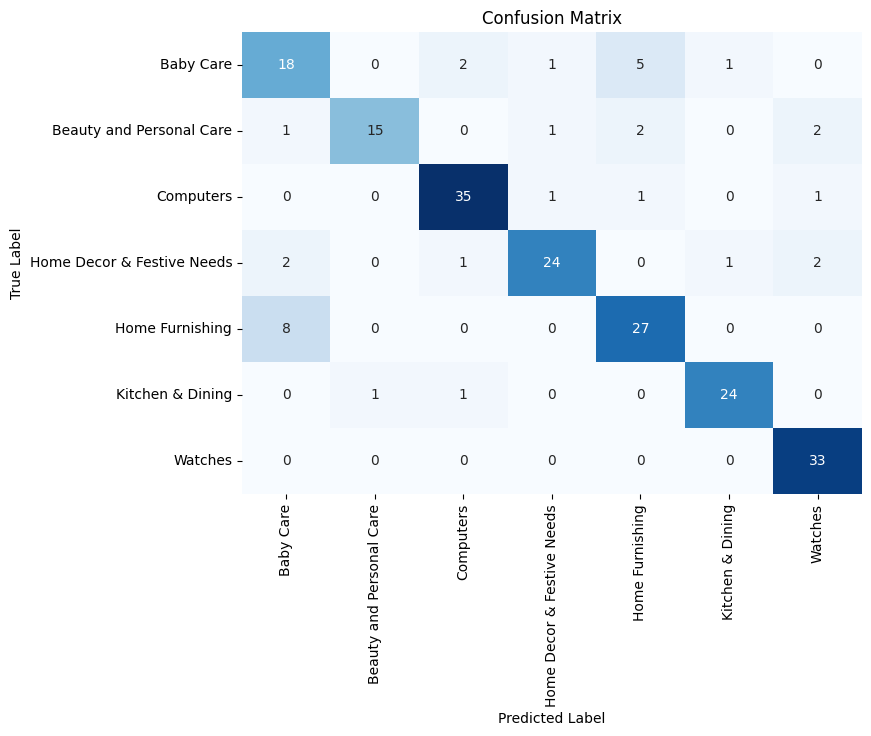

In [ ]:
def plot_confusion_matrix(model, X_test_images, y_test_categorical, categories):
    # Prédire les classes pour les données de test
    y_test_pred = model.predict(X_test_images)

    # Convertir les prédictions en classes (catégories)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)

    # Classes réelles
    y_test_true_classes = np.argmax(y_test_categorical, axis=1)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

    # Afficher la matrice de confusion avec une heatmap
    df_cm = pd.DataFrame(conf_matrix, index=categories, columns=categories)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Récupérer les noms des catégories
categories = encoder.classes_

# Utiliser la fonction après l'entraînement
plot_confusion_matrix(model_optimized, X_test_images, y_test_categorical, categories)

## <font color='red'>5. Conclusion</font><a class="anchor" id="partie5"></a>

Au terme de cette étude, plusieurs méthodes de classification automatique des produits ont été testées à partir des images en utilisant des approches variées de deep learning. L’objectif était de comparer leur efficacité et de choisir la méthode la plus adaptée en fonction des performances observées. Trois variantes de classification ont été étudiées :

- Méthode sans optimisation d'hyperparamètres : La première approche a montré des résultats corrects avec une précision d’entraînement de 93.21% et une précision de validation de 81.90%. Cependant, les courbes d’apprentissage montrent une légère tendance à l'overfitting, avec une augmentation continue de l’écart entre la perte d’entraînement et la perte de validation.

- Méthode avec optimisation des hyperparamètres : Après ajustement des hyperparamètres (comme le type d’optimiseur, le nombre de neurones dans les couches fully connected et le taux de dropout), cette variante a permis d’obtenir des résultats plus stables. Les courbes d’apprentissage montrent que le modèle parvient à un bon compromis entre l’entraînement et la validation, avec une précision de validation de 78.10%. Le modèle ne présente ni biais significatif ni surajustement, ce qui en fait la meilleure approche parmi celles testées.

- Méthode avec data augmentation : L’utilisation de la data augmentation a permis de stabiliser les courbes d’apprentissage et d’améliorer légèrement la précision de validation (85.24%). Cependant, cette méthode présente une forte volatilité au niveau des courbes de précision, avec des fluctuations marquées, ce qui pourrait rendre la généralisation du modèle plus incertaine.

Choix de la méthode optimale : En analysant les résultats des trois variantes, la méthode avec optimisation des hyperparamètres semble être la plus prometteuse pour la classification des produits à partir des images. Elle offre une stabilité accrue, un bon équilibre entre les performances d'entraînement et de validation, et ne présente pas de biais ou d’overfitting significatif.